<div style="color: orange; font-size: 25px; text-align: center;">
In the name of Allah
</div>

<div style="font-size: 20px; text-align: center;">
“Points Practice of Electromyogram Signal Processing in Order to Identify Hand Movements”
</div>

<div style="font-size: 20px; text-align: center;">
Group 7<br>
Ali Sadeghian 400101464<br> 
Amirhossein Naghdi 400102169<br>
Kiyana Kalantary 400101804
</div>

<div style="font-size: 18px">
The purpose of this exercise is to map the electromyography signal to the corresponding gesture. The muscle signals are classified by machine learning classifiers that are generally composed of four interconnected parts, using features that are extracted in the following ways. Raw pattern recognition systems, EMG preprocessing, data windowing, feature extraction, and classification. The signals are divided into a set of overlapping windows with limited length. A set of relevant criteria, called features, is extracted from each window, which effectively maps the signals to a lower-dimensional space and increases their information density. Then, a classifier detects the signal patterns and separates them into predefined classes.
</div>

<div style="font-size: 18px;color : orange;">
Import part
</div>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.io
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix

<div style="font-size: 18px;color : orange;">
Fetch Data
</div>
<div style="font-size: 18px">
The data for person 1 and 14 from the NinaPro database 2( https://ninapro.hevs.ch/instructions/DB2.html ) was downloaded(Data size is 150MB for each person, so I can't  attach files).The EMG channels 9 and 11 were used from the EMG data to analyze the data. The stimulus data was also used to separate rest and activity times.The sampling frequency of 2kHz has been reported on the site.
</div>

In [73]:
#  Fecth data
mat = scipy.io.loadmat('S14_E1_A1.mat')
#mat = scipy.io.loadmat('S1_E1_A1.mat')
data = mat['emg']
repetition1 = mat['repetition']
stimulus1 = mat['stimulus']

# data from main spots (Channels)
data1 = data[0:,8]
data2 = data[0:,10]

#  Time
fs = 2000
[array_length , array_with] = len(data),len(data[0])
t1 = np.linspace(0,array_length/fs,array_length)

<div style="font-size: 18px;color : orange;">
PART 1 
</div>   
<div style="font-size: 18px">
This section aims to remove the noise of city power, its various harmonics, and calibration error noise using filters.<br>
To remove DC noise, a high-pass Butterworth filter with a cutoff frequency of 1 Hz is used. To remove city power noise and its various harmonics, a bandpass Butterworth filter with different bandwidths is used.
</div>     

In [74]:
def butterworth_filter(data, fs, fc, order=1):
    # calculate the normalized cutoff frequency
    w = fc / (fs / 2)
    # create a Butterworth filter
    b, a = signal.butter(order, w, 'high')
    # apply the filter to the vector
    return signal.filtfilt(b, a, data)

def remove_city_electricity(vector, fs):
    # define the frequency of the city electricity
    f1 = 50
    # define the bandwidth of the bandstop filter
    A = 5
    # loop over the first 10 harmonics of the city electricity
    for i in range(1, 10):
        # create a bandstop filter to remove the harmonic
        b, a = signal.butter(4, [(i*f1-A) / (fs / 2), (i*f1+A) / (fs / 2)], 'bandstop')
        vector = signal.filtfilt(b, a, vector)
    # increase the bandwidth for higher harmonics
    A = 10  
    # loop over the next 10 harmonics of the city electricity
    for i in range(10, 20):
        # create a bandstop filter to remove the harmonic
        b, a = signal.butter(4, [(i*f1-A) / (fs / 2), (i*f1+A) / (fs / 2)], 'bandstop')
        vector = signal.filtfilt(b, a, vector)    
    # return the filtered vector
    return vector

def calculate_spectrum(vector, fs, TIT):
    # get the length of the vector
    n = len(vector)
    # create an array of indices
    k = np.arange(n)
    # calculate the duration of the signal
    t = n / fs
    # calculate the frequency of each index
    frq = k / t
    # only keep the positive half of the spectrum
    frq = frq[range(n // 2)]
    # calculate the Fourier transform of the vector
    Y = np.fft.fft(vector) / n
    # only keep the positive half of the spectrum
    Y = Y[range(n // 2)]
    # plot the spectrum
    plt.plot(frq, abs(Y), 'r')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(TIT)
    plt.show()

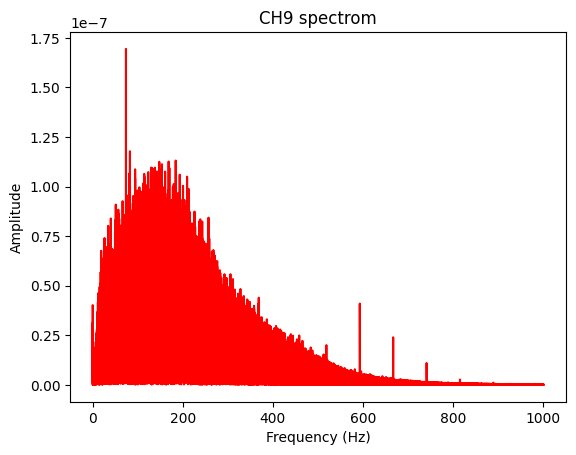

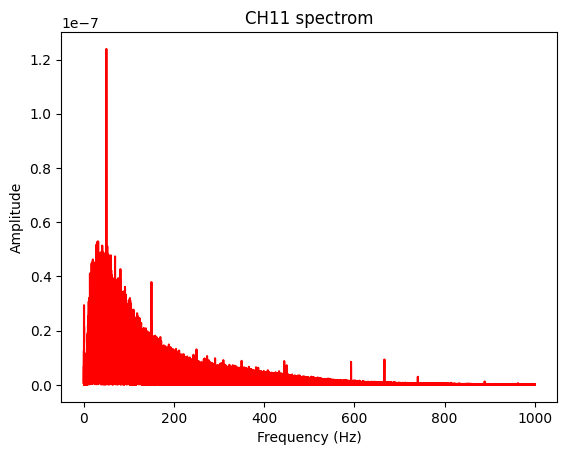

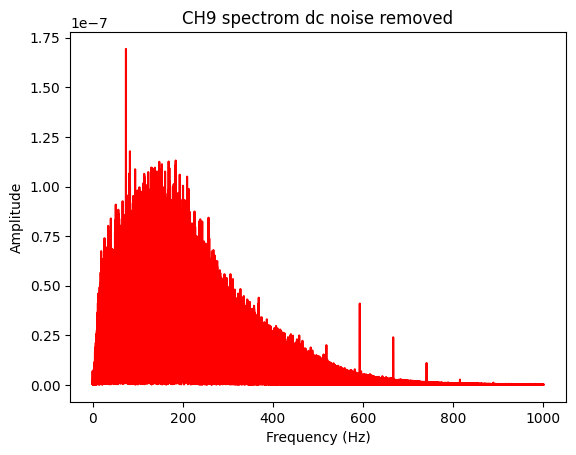

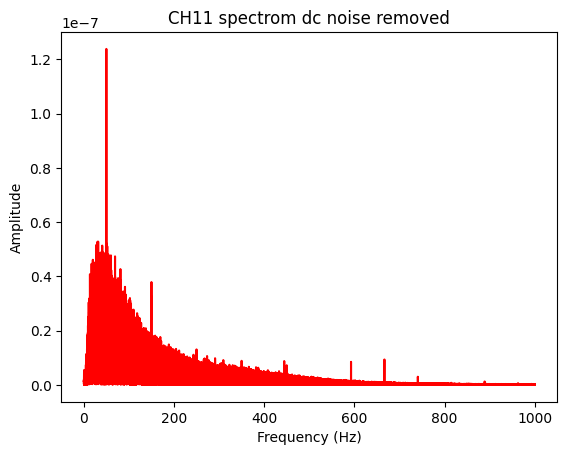

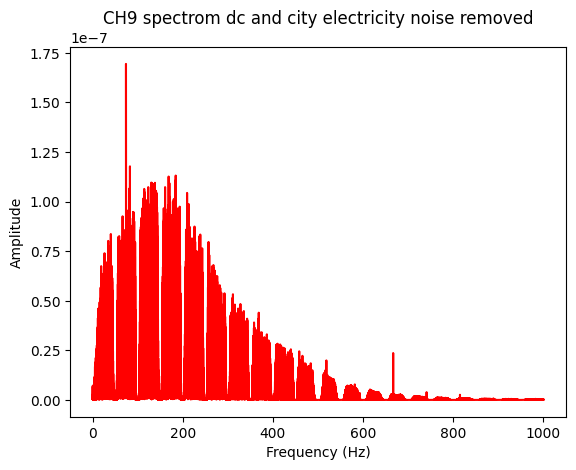

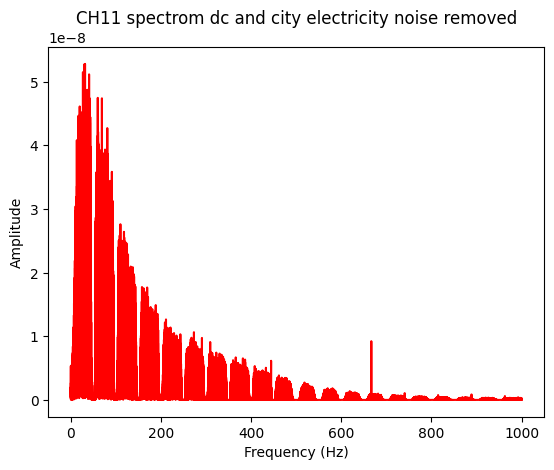

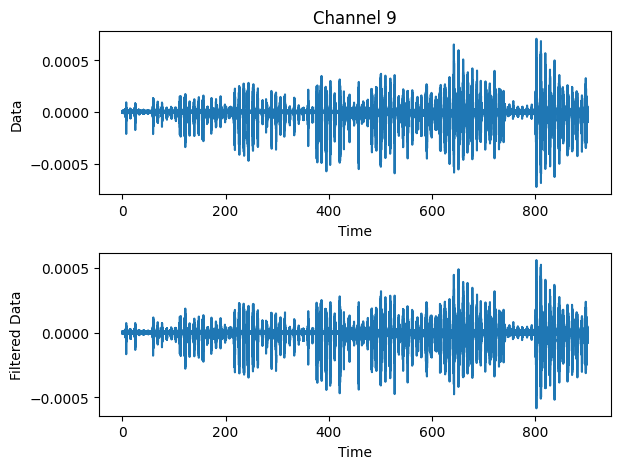

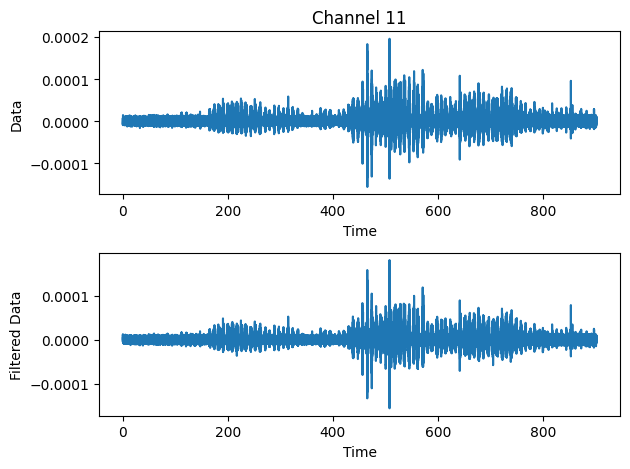

In [75]:
# calculate the spectrum of two data vectors
calculate_spectrum(data1,fs,"CH9 spectrom")
calculate_spectrum(data2,fs,"CH11 spectrom")

# define the cutoff frequency for the high-pass filter
fc = 1

# apply the high-pass filter to the vector to remove the DC component
data1_filtered = butterworth_filter(data1, fs, fc)
data2_filtered = butterworth_filter(data2, fs, fc)

# calculate the spectrum of the filtered vectors
calculate_spectrum(data1_filtered,fs,"CH9 spectrom dc noise removed")
calculate_spectrum(data2_filtered,fs,"CH11 spectrom dc noise removed")

# apply the bandstop filters to the vector to remove the city electricity noise and its harmonics
data1_filtered = remove_city_electricity(data1_filtered,fs)
data2_filtered = remove_city_electricity(data2_filtered,fs)

# calculate the spectrum of the filtered vectors
calculate_spectrum(data1_filtered,fs,"CH9 spectrom dc and city electricity noise removed")
calculate_spectrum(data2_filtered,fs,"CH11 spectrom dc and city electricity noise removed")


# plot
plt.subplot(2,1,1)
plt.plot(t1,data1)
plt.title('Channel 9')
plt.ylabel('Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(t1, data1_filtered)
plt.ylabel('Filtered Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.plot(t1,data2)
plt.title('Channel 11')
plt.ylabel('Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(t1, data2_filtered)
plt.ylabel('Filtered Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

<div style="font-size: 18px">
As we can see in the spectrum, city noise has affected the main signal up to a frequency of 600 Hz, which can be significantly improved by applying a filter.
</div> 

<div style="font-size: 18px;color : orange;">
PART 2
</div>  
<div style="font-size: 18px">
In this section, we first separate the movement content from the rest using the sEMG signal. Then, we select 4 movements similar to what we did in the laboratory and separate the relevant content. We separate the data into training and test data, then normalize the movement data for the next section. The reason we extract the movement data first and then normalize it is that when normalizing, the data vectors must be normalized, not the raw data, which includes everything including rest time.<br>
Data is often separated into training and test sets to account for over-training of models. Validation sets can also be used to compare the performance of different models to each other. When you use test/validation sets, you can get an idea of how over-fitted your model is and how it may perform on additional data added later. It is also helpful to compare different models. If both models were made using the answer key (the validation data), then they may be over-fit to the answer-key
</div>   

<h1 style="text-align: center;">Ex1</h1>
<h1 style="text-align: center;"><img src="EXE 1(5).JPG"  style="width: 150px;"/></h1>
<h1 style="text-align: center;">Ex2</h1>
<h1 style="text-align: center;"><img src="EXE 2(6).JPG"  style="width: 150px;"/></h1>
<h1 style="text-align: center;">Ex3</h1>
<h1 style="text-align: center;"><img src="EXE 3(13).JPG"  style="width: 150px;"/></h1>
<h1 style="text-align: center;">Ex4</h1>
<h1 style="text-align: center;"><img src="EXE 4(14).JPG"  style="width: 150px;"/></h1>

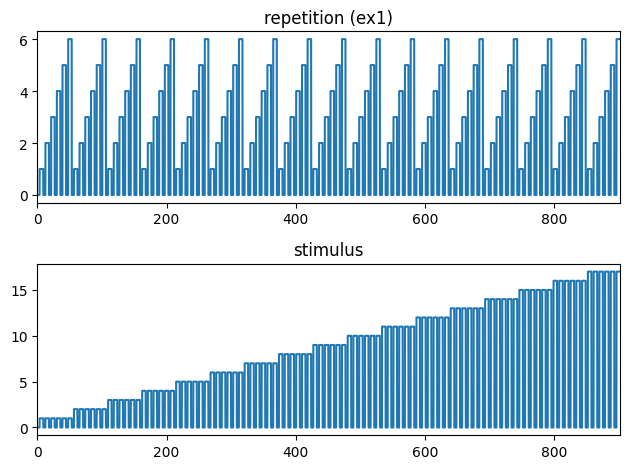

In [76]:
xxx = t1[-1]
plt.subplot(2,1,1)
plt.plot(t1, repetition1)
plt.title('repetition (ex1)')
plt.xlim([0,xxx])
plt.subplot(2,1,2)
plt.plot(t1, stimulus1)
plt.title('stimulus')
plt.xlim([0,xxx])
plt.tight_layout()
plt.show()

<div style="font-size: 18px">
When the stimulus is equal to 0, it means that the person is at rest
</div>   

In [77]:
import numpy as np

# Function to extract nonzero elements from two vectors
def extract_nonzero_elements(v1, v2):
    indices = np.nonzero(v2)[0]
    result = np.split(v1[indices], np.where(np.diff(indices) != 1)[0] + 1)
    return [x.tolist() for x in result]

# Function to normalize vectors using mean and standard deviation
def normalize_vectors(vectors):
    means = np.mean(vectors, axis=0)
    stds = np.std(vectors, axis=0)
    return (vectors - means) / stds

# Function to normalize vectors using min-max scaling
def normalize_vectors_PP(vectors):
    mins = np.min(vectors, axis=0)
    maxs = np.max(vectors, axis=0)
    return (vectors - mins) / (maxs - mins)

# Function to split a list into train and test lists
def split_list(lst):
    train_list = [lst[i] for i in range(len(lst)) if i % 6 == 0 or i % 6 == 1 or i % 6 == 2 or i % 6 == 4]
    test_list = [lst[i] for i in range(len(lst)) if i % 6 == 3 or i % 6 == 5]
    return train_list, test_list

# Function to preprocess data
def preprocess_data(data1_filtered, stimulus1, data2_filtered, t1):
    DATAF1 = extract_nonzero_elements(data1_filtered, stimulus1)
    DATAF2 = extract_nonzero_elements(data2_filtered, stimulus1)
    TIME = extract_nonzero_elements(t1, stimulus1)
    Data1_train, Data1_test = split_list(DATAF1)
    Data2_train, Data2_test = split_list(DATAF2)
    Time_train, Time_test = split_list(TIME)

    Data1_test_N = [normalize_vectors_PP(x) for x in Data1_test]
    Data1_train_N = [normalize_vectors_PP(x) for x in Data1_train]
    Data2_train_N = [normalize_vectors(x) for x in Data2_train]
    Data2_test_N = [normalize_vectors(x) for x in Data2_test]

    return Data1_test_N, Data1_train_N, Data2_train_N, Data2_test_N, Time_train, Time_test

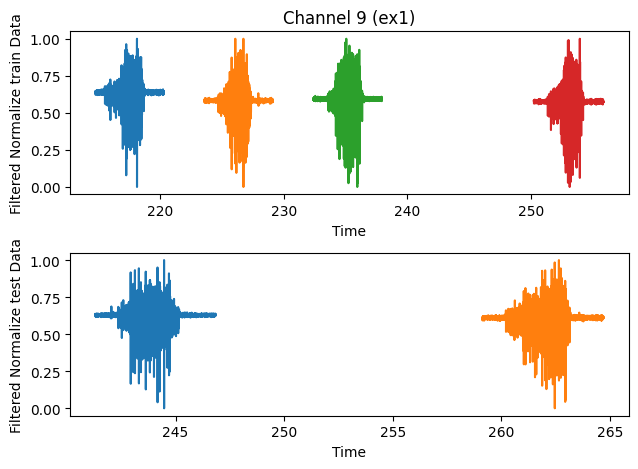

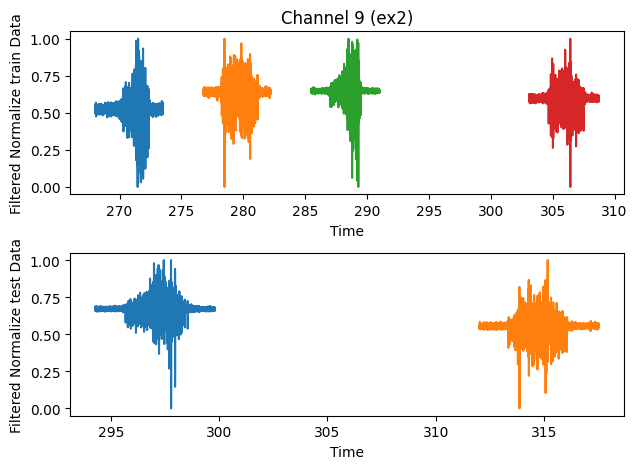

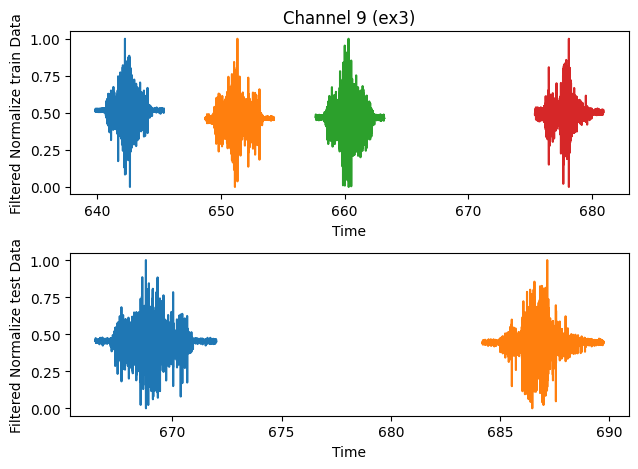

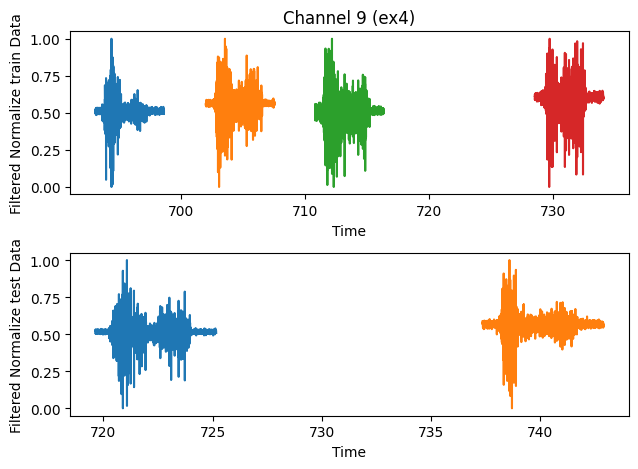

In [78]:
Data1_test_N, Data1_train_N, Data2_train_N, Data2_test_N, Time1_train, 
Time1_test = preprocess_data(data1_filtered, stimulus1, data2_filtered, t1)    

# plot
plt.subplot(2,1,1)
plt.plot(Time1_train[16],Data1_train_N[16],Time1_train[17],Data1_train_N[17],
         Time1_train[18],Data1_train_N[18],Time1_train[19],Data1_train_N[19])
plt.title('Channel 9 (ex1)')
plt.ylabel('Filtered Normalize train Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(Time1_test[8], Data1_test_N[8],Time1_test[9], Data1_test_N[9])
plt.ylabel('Filtered Normalize test Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.plot(Time1_train[20],Data1_train_N[20],Time1_train[21],Data1_train_N[21],
         Time1_train[22],Data1_train_N[22],Time1_train[23],Data1_train_N[23])
plt.title('Channel 9 (ex2)')
plt.ylabel('Filtered Normalize train Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(Time1_test[10], Data1_test_N[10],Time1_test[11], Data1_test_N[11])
plt.ylabel('Filtered Normalize test Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.plot(Time1_train[48],Data1_train_N[48],Time1_train[49],Data1_train_N[49],
         Time1_train[50],Data1_train_N[50],Time1_train[51],Data1_train_N[51])
plt.title('Channel 9 (ex3)')
plt.ylabel('Filtered Normalize train Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(Time1_test[24], Data1_test_N[24],Time1_test[25], Data1_test_N[25])
plt.ylabel('Filtered Normalize test Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.plot(Time1_train[52],Data1_train_N[52],Time1_train[53],Data1_train_N[53],
         Time1_train[54],Data1_train_N[54],Time1_train[55],Data1_train_N[55])
plt.title('Channel 9 (ex4)')
plt.ylabel('Filtered Normalize train Data')
plt.xlabel('Time')
plt.subplot(2,1,2)
plt.plot(Time1_test[26], Data1_test_N[26],Time1_test[27], Data1_test_N[27])
plt.ylabel('Filtered Normalize test Data')
plt.xlabel('Time')
plt.tight_layout()
plt.show()


# Saving data
EX1_Train_CH9  = [Data1_train_N[16],Data1_train_N[17],Data1_train_N[18],Data1_train_N[19]]
EX1_Train_CH11 = [Data2_train_N[16],Data2_train_N[17],Data2_train_N[18],Data2_train_N[19]]
EX1_Train_Time = [Time1_train[16],Time1_train[17],Time1_train[18],Time1_train[19]]

EX1_Test_CH9  = [Data1_test_N[8], Data1_test_N[9]]
EX1_Test_CH11 = [Data2_test_N[8], Data2_test_N[9]]
EX1_Test_Time = [Time1_test[8],Time1_test[9]]

EX2_Train_CH9  = [Data1_train_N[20],Data1_train_N[21],Data1_train_N[22],Data1_train_N[23]]
EX2_Train_CH11 = [Data2_train_N[20],Data2_train_N[21],Data2_train_N[22],Data2_train_N[23]]
EX2_Train_Time = [Time1_train[20],Time1_train[21],Time1_train[22],Time1_train[23]]

EX2_Test_CH9  = [Data1_test_N[10], Data1_test_N[11]]
EX2_Test_CH11 = [Data2_test_N[10], Data2_test_N[11]]
EX2_Test_Time = [Time1_test[10],Time1_test[11]]

EX3_Train_CH9  = [Data1_train_N[48],Data1_train_N[49],Data1_train_N[50],Data1_train_N[51]]
EX3_Train_CH11 = [Data2_train_N[48],Data2_train_N[49],Data2_train_N[50],Data2_train_N[51]]
EX3_Train_Time = [Time1_train[48],Time1_train[49],Time1_train[50],Time1_train[51]]

EX3_Test_CH9  = [Data1_test_N[24], Data1_test_N[25]]
EX3_Test_CH11 = [Data2_test_N[24], Data2_test_N[25]]
EX3_Test_Time = [Time1_test[24],Time1_test[25]]

EX4_Train_CH9  = [Data1_train_N[52],Data1_train_N[53],Data1_train_N[54],Data1_train_N[55]]
EX4_Train_CH11 = [Data2_train_N[52],Data2_train_N[53],Data2_train_N[54],Data2_train_N[55]]
EX4_Train_Time = [Time1_train[52],Time1_train[53],Time1_train[54],Time1_train[55]]

EX4_Test_CH9  = [Data1_test_N[26], Data1_test_N[27]]
EX4_Test_CH11 = [Data2_test_N[26], Data2_test_N[27]]
EX4_Test_Time = [Time1_test[26],Time1_test[27]]

<div style="font-size: 18px;color : orange;">
PART 3
</div>  
<div style="font-size: 18px">
Signal Windowing and Overlapping with 200ms Windows and 190ms Overlap (10ms Step Size)
</div>  

In [79]:
# Function to extract windows from a vector
def extract_windows(fs, vector):
    window_width = int(fs * 0.2)  # Width of the window (200 ms at the provided sampling frequency)
    window_shift = int(fs * 0.01)  # Shift between consecutive windows (100 ms at the provided sampling frequency)
    windows = []
    for i in range(0, len(vector) - window_width, window_shift):
        window = vector[i:i + window_width]  # Extract the window from the vector
        windows.append(window)  # Add the window to the list of windows
    return list(windows)  # Return the list of extracted windows

# Function to save windows for all channels in the data
def save_windows(fs, DATA):
    DATA_200ms = (
        extract_windows(fs, DATA[0]) 
        + extract_windows(fs, DATA[1]) 
        + extract_windows(fs, DATA[2]) 
        + extract_windows(fs, DATA[3])
    )  # Combine windows from all channels into a single list
    return DATA_200ms  # Return the combined list of windows

# Function to save windows for two channels in the data
def save_windows_t(fs, DATA):
    DATA_200ms = extract_windows(fs, DATA[0]) + extract_windows(fs, DATA[1])  # Extract windows for two channels
    return DATA_200ms  # Return the list of windows

In [80]:
# Save windows for EX1 training data for channel 9
EX1_Train_CH9_200ms = save_windows(fs, EX1_Train_CH9)

# Save windows for EX1 training data for channel 11
EX1_Train_CH11_200ms = save_windows(fs, EX1_Train_CH11)

# Save windows for EX1 testing data for channels 9 and 11
EX1_Test_CH9_200ms = save_windows_t(fs, EX1_Test_CH9)
EX1_Test_CH11_200ms = save_windows_t(fs, EX1_Test_CH11)

# Save windows for EX2 training data for channel 9
EX2_Train_CH9_200ms = save_windows(fs, EX2_Train_CH9)

# Save windows for EX2 training data for channel 11
EX2_Train_CH11_200ms = save_windows(fs, EX2_Train_CH11)

# Save windows for EX2 testing data for channels 9 and 11
EX2_Test_CH9_200ms = save_windows_t(fs, EX2_Test_CH9)
EX2_Test_CH11_200ms = save_windows_t(fs, EX2_Test_CH11)

# Save windows for EX3 training data for channel 9
EX3_Train_CH9_200ms = save_windows(fs, EX3_Train_CH9)

# Save windows for EX3 training data for channel 11
EX3_Train_CH11_200ms = save_windows(fs, EX3_Train_CH11)

# Save windows for EX3 testing data for channels 9 and 11
EX3_Test_CH9_200ms = save_windows_t(fs, EX3_Test_CH9)
EX3_Test_CH11_200ms = save_windows_t(fs, EX3_Test_CH11)

# Save windows for EX4 training data for channel 9
EX4_Train_CH9_200ms = save_windows(fs, EX4_Train_CH9)

# Save windows for EX4 training data for channel 11
EX4_Train_CH11_200ms = save_windows(fs, EX4_Train_CH11)

# Save windows for EX4 testing data for channels 9 and 11
EX4_Test_CH9_200ms = save_windows_t(fs, EX4_Test_CH9)
EX4_Test_CH11_200ms = save_windows_t(fs, EX4_Test_CH11)

<div style="font-size: 18px;color : orange;">
PART 4
</div>  
<div style="font-size: 18px">
Feature Extraction from Dataframe Windows: At Least Three Features per Window with Labels(I Extract 6 Features)
</div> 

In [84]:
# Function to calculate Mean Absolute Value (MAV) of vectors
def calculate_mav(vectors):
    mav = []
    for vector in vectors:
        mav.append(sum(abs(x) for x in vector) / len(vector))
    return mav

# Function to calculate Standard Deviation (STD) of vectors
def calculate_std(vectors):
    std = []
    for vector in vectors:
        std.append(np.sqrt(np.sum(np.square(vector - np.mean(vector))) / (len(vector) - 1)))
    return std

# Function to calculate Variance (VAR) of vectors
def calculate_var(vectors):
    var = []
    for vector in vectors:
        var.append(np.sum(np.square(vector)) / (len(vector) - 1))
    return var

# Function to calculate waveform length (WL) of vectors
def calculate_wl(vectors):
    wl = []
    for vector in vectors:
        wl.append(sum(abs(vector[i] - vector[i-1]) for i in range(1, len(vector))))
    return wl

# Function to calculate zero crossings (ZC) of vectors
def calculate_zc(vectors):
    zc = []
    for vector in vectors:
        zc.append(np.sum(np.abs(np.diff(np.sign(vector))) / 2))
    return zc

# Function to calculate Root Mean Square (RMS) of vectors
def calculate_rms(vectors):
    rms = []
    for vector in vectors:
        rms.append(np.sqrt(np.sum(np.square(vector)) / len(vector)))
    return rms

# Function to calculate number of peaks (NP) of vectors
def calculate_np(vectors):
    np = []
    for vector in vectors:
        np.append(len(np.where(np.diff(np.sign(np.array(vector))))[0]))
    return np

# Function to calculate Slope Sign Changes (SSC) of vectors
def calculate_ssc(vectors):
    ssc = []
    threshold = 0.2
    for vector in vectors:
        ssc.append(sum(1 for i in range(1, len(vector)-1) if 
                       (vector[i] - vector[i-1]) * (vector[i] - vector[i+1]) > 0 and abs(vector[i] - vector[i-1]) 
                       > threshold and abs(vector[i] - vector[i+1]) > threshold))
    return ssc

# Function to calculate Integrated Absolute Value (IAV) of vectors
def calculate_iav(vectors):
    iav = []
    for vector in vectors:
        iav.append(np.sum(np.abs(vector)))
    return iav

# Function to calculate all features using the above functions
def calculate_features(data):
    mav = calculate_mav(data)
    std = calculate_std(data)
    var = calculate_var(data)
    wl = calculate_wl(data)
    rms = calculate_rms(data)
    #zc = calculate_zc(data)
    #np = calculate_np(data)
    #ssc = calculate_ssc(data)
    
    return mav, std, var, wl,rms, iav#,np,ssc,zc

In [85]:
# Calculate features for CH9 and CH11 for EX1
EX1_Train_CH9_mav_wl_ssc = calculate_feutures(EX1_Train_CH9_200ms)
EX1_Train_CH11_mav_wl_ssc = calculate_feutures(EX1_Train_CH11_200ms)
EX1_Test_CH9_mav_wl_ssc = calculate_feutures(EX1_Test_CH9_200ms)
EX1_Test_CH11_mav_wl_ssc = calculate_feutures(EX1_Test_CH11_200ms)

# Calculate features for CH9 and CH11 for EX2
EX2_Train_CH9_mav_wl_ssc = calculate_feutures(EX2_Train_CH9_200ms)
EX2_Train_CH11_mav_wl_ssc = calculate_feutures(EX2_Train_CH11_200ms)
EX2_Test_CH9_mav_wl_ssc = calculate_feutures(EX2_Test_CH9_200ms)
EX2_Test_CH11_mav_wl_ssc = calculate_feutures(EX2_Test_CH11_200ms)

# Calculate features for CH9 and CH11 for EX3
EX3_Train_CH9_mav_wl_ssc = calculate_feutures(EX3_Train_CH9_200ms)
EX3_Train_CH11_mav_wl_ssc = calculate_feutures(EX3_Train_CH11_200ms)
EX3_Test_CH9_mav_wl_ssc = calculate_feutures(EX3_Test_CH9_200ms)
EX3_Test_CH11_mav_wl_ssc = calculate_feutures(EX3_Test_CH11_200ms)

# Calculate features for CH9 and CH11 for EX4
EX4_Train_CH9_mav_wl_ssc = calculate_feutures(EX4_Train_CH9_200ms)
EX4_Train_CH11_mav_wl_ssc = calculate_feutures(EX4_Train_CH11_200ms)
EX4_Test_CH9_mav_wl_ssc = calculate_feutures(EX4_Test_CH9_200ms)
EX4_Test_CH11_mav_wl_ssc = calculate_feutures(EX4_Test_CH11_200ms)

In [86]:
# This function creates a new list by transposing the main list and adding a label for each new sublist
def create_new_list(main_list, Label):
    new_list = []
    LABEL = []  # Empty list to store labels
    for i in range(len(main_list[0])):
        new_sublist = []
        for sublist in main_list:
            new_sublist.append(sublist[i])  # Transpose the list
        new_list.append(new_sublist)  # Append the transposed sublist to the new list
        LABEL.append(Label)  # Append the label
    return list(new_list), list(LABEL)  # Return the transposed list and the list of labels


In [87]:
# Creating new lists for training data and labels
train_data1, train_labels1 = create_new_list(EX1_Train_CH9_mav_wl_ssc, 0)
train_data2, train_labels2 = create_new_list(EX1_Train_CH11_mav_wl_ssc, 0)
train_data3, train_labels3 = create_new_list(EX2_Train_CH9_mav_wl_ssc, 1)
train_data4, train_labels4 = create_new_list(EX2_Train_CH11_mav_wl_ssc, 1)
train_data5, train_labels5 = create_new_list(EX3_Train_CH9_mav_wl_ssc, 2)
train_data6, train_labels6 = create_new_list(EX3_Train_CH11_mav_wl_ssc, 2)
train_data7, train_labels7 = create_new_list(EX4_Train_CH9_mav_wl_ssc, 3)
train_data8, train_labels8 = create_new_list(EX4_Train_CH11_mav_wl_ssc, 3)
# Combining the training data and labels
train_dataC9 = train_data1 + train_data3 + train_data5 + train_data7
train_labelsC9 = train_labels1 + train_labels3 + train_labels5 + train_labels7
train_dataC11 = train_data2 + train_data4 + train_data6 + train_data8
train_labelsC11 = train_labels2 + train_labels4 + train_labels6 + train_labels8

# Creating new lists for test data and labels
test_data1, test_labels1 = create_new_list(EX1_Test_CH9_mav_wl_ssc, 0)
test_data2, test_labels2 = create_new_list(EX1_Test_CH11_mav_wl_ssc, 0)
test_data3, test_labels3 = create_new_list(EX2_Test_CH9_mav_wl_ssc, 1)
test_data4, test_labels4 = create_new_list(EX2_Test_CH11_mav_wl_ssc, 1)
test_data5, test_labels5 = create_new_list(EX3_Test_CH9_mav_wl_ssc, 2)
test_data6, test_labels6 = create_new_list(EX3_Test_CH11_mav_wl_ssc, 2)
test_data7, test_labels7 = create_new_list(EX4_Test_CH9_mav_wl_ssc, 3)
test_data8, test_labels8 = create_new_list(EX4_Test_CH11_mav_wl_ssc, 3)
# Combining the test data and labels
test_dataC9 = test_data1 + test_data3 + test_data5 + test_data7
test_labelsC9 = test_labels1 + test_labels3 + test_labels5 + test_labels7
test_dataC11 = test_data2 + test_data4 + test_data6 + test_data8
test_labelsC11 = test_labels2 + test_labels4 + test_labels6 + test_labels8

<div style="font-size: 18px;color : orange;">
PART 5
</div>  
<div style="font-size: 18px">
Training and Testing Machine Learning Models: Random Forest, KNN, LDA, and SVM. Reporting Results in Confusion Matrix Format and Final Accuracy for Each Model. ( I do this part with 3 models)
</div> 

In [88]:
# Train LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_dataC9, train_labelsC9)

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_dataC9, train_labelsC9)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_model.fit(train_dataC9, train_labelsC9)

# Predict using test data
lda_pred = lda_model.predict(test_dataC9)
knn_pred = knn_model.predict(test_dataC9)
rf_pred  = rf_model.predict(test_dataC9)

# Calculate accuracy of each model
lda_acc = accuracy_score(test_labelsC9, lda_pred)
knn_acc = accuracy_score(test_labelsC9, knn_pred)
rf_acc = accuracy_score(test_labelsC9, rf_pred)


# Calculate confusion matrix 
lda_cm = confusion_matrix(test_labelsC9, lda_pred)
knn_cm = confusion_matrix(test_labelsC9, knn_pred)
rf_cm = confusion_matrix(test_labelsC9, rf_pred)


# Print accuracy of each model
print("Chanal 9")
print(f"LDA accuracy: {lda_acc}")
print(f"KNN accuracy: {knn_acc}")
print(f"Random Forest accuracy: {rf_acc}")


# Print confusion matrix
print("LDA confusion matrix:")
print(lda_cm)
print("KNN confusion matrix:")
print(knn_cm)
print("Random Forest confusion matrix:")
print(rf_cm)

Chanal 9
LDA accuracy: 0.7581928838951311
KNN accuracy: 0.6329588014981273
Random Forest accuracy: 0.7467228464419475
LDA confusion matrix:
[[ 730  341    0    0]
 [  11  551    0  505]
 [   0    0 1068    0]
 [ 152    0   24  890]]
KNN confusion matrix:
[[ 524   10    0  537]
 [   0  535    0  532]
 [   0    0 1068    0]
 [   0    0  489  577]]
Random Forest confusion matrix:
[[ 534    0    0  537]
 [   0 1001    0   66]
 [   0    0 1068    0]
 [   0    0  479  587]]


In [89]:
# Train LDA model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(train_dataC11, train_labelsC11)

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_dataC11, train_labelsC11)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf_model.fit(train_dataC11, train_labelsC11)

# Predict using test data
lda_pred = lda_model.predict(test_dataC11)
knn_pred = knn_model.predict(test_dataC11)
rf_pred  = rf_model.predict(test_dataC11)

# Calculate accuracy of each model
lda_acc = accuracy_score(test_labelsC11, lda_pred)
knn_acc = accuracy_score(test_labelsC11, knn_pred)
rf_acc = accuracy_score(test_labelsC11, rf_pred)


# Calculate confusion matrix 
lda_cm = confusion_matrix(test_labelsC9, lda_pred)
knn_cm = confusion_matrix(test_labelsC9, knn_pred)
rf_cm = confusion_matrix(test_labelsC9, rf_pred)


# Print accuracy of each model
print("Chanal 11")
print(f"LDA accuracy: {lda_acc}")
print(f"KNN accuracy: {knn_acc}")
print(f"Random Forest accuracy: {rf_acc}")

# Print confusion matrix
print("LDA confusion matrix:")
print(lda_cm)
print("KNN confusion matrix:")
print(knn_cm)
print("Random Forest confusion matrix:")
print(rf_cm)

Chanal 11
LDA accuracy: 0.5086610486891385
KNN accuracy: 0.6093164794007491
Random Forest accuracy: 0.6018258426966292
LDA confusion matrix:
[[790 220  32  29]
 [652 405   0  10]
 [ 51   0 397 620]
 [ 17   0 468 581]]
KNN confusion matrix:
[[866 160  35  10]
 [394 637  28   8]
 [ 46   8 503 511]
 [ 14   1 454 597]]
Random Forest confusion matrix:
[[872 136  48  15]
 [449 567  37  14]
 [ 52   3 470 543]
 [ 13   1 390 662]]


<div style="font-size: 18px">
14th-person data results
</div> 



<div style="font-size: 18px">

CH9<br>    
| **Model** | **Accuracy** | **Confusion Matrix** |
|-----------|--------------|---------------------|
| LDA       | **0.758**        | [[730, 341, 0, 0], [11, 551, 0, 505], [0, 0, 1068, 0], [152, 0, 24, 890]] |
| KNN       | **0.633**        | [[524, 10, 0, 537], [0, 535, 0, 532], [0, 0, 1068, 0], [0, 0, 489, 577]] |
| Random Forest | **0.747** | [[534, 0, 0, 537], [0, 1001, 0, 66], [0, 0, 1068, 0], [0, 0, 479, 587]] |


CH11<br>
| **Model** | **Accuracy** | **Confusion Matrix** |
|-----------|--------------|---------------------|
| LDA       | **0.509**        | [[790, 220, 32, 29], [652, 405, 0, 10], [51, 0, 397, 620], [17, 0, 468, 581]] |
| KNN       | **0.609**        | [[866, 160, 35, 10], [394, 637, 28, 8], [46, 8, 503, 511], [14, 1, 454, 597]] |
| Random Forest | **0.602** | [[872, 136, 48, 15], [449, 567, 37, 14], [52, 3, 470, 543], [13, 1, 390, 662]] |

</div>


<div style="font-size: 18px">
first-person data results
</div> 

<div style="font-size: 18px">

CH9<br>     
| **Model** | **Accuracy** | **Confusion Matrix** |
|-----------|--------------|---------------------|
| LDA       | **0.337**    | [[4, 227, 830, 3], [369, 685, 14, 0], [0, 117, 747, 203], [251, 542, 273, 4]] |
| KNN       | 0.241        | [[0, 86, 524, 454], [0, 495, 573, 0], [28, 0, 534, 505], [0, 26, 1044, 0]] |
| Random Forest | 0.241    | [[0, 134, 527, 403], [0, 496, 572, 0], [28, 0, 534, 505], [0, 12, 1058, 0]] |


CH11<br>
| **Model** | **Accuracy** | **Confusion Matrix** |
|-----------|--------------|---------------------|
| LDA       | **0.309**     | [[530, 216, 161, 157], [360, 264, 307, 137], [344, 217, 408, 98], [74, 156, 721, 119]] |
| KNN       | **0.391**     | [[443, 290, 223, 108], [381, 400, 161, 126], [355, 268, 347, 97], [232, 256, 104, 478]] |
| Random Forest | **0.420** | [[551, 260, 180, 73], [503, 354, 79, 132], [443, 239, 319, 66], [180, 191, 132, 567]] |

</div>


<div style="font-size: 18px;color : orange;">
PART 6
</div>  
<div style="font-size: 18px">
The challenge of processing electromyography (EMG) signals to identify hand movements lies in finding the proper filters and features to achieve proper accuracy. The quality of the data is also a critical factor in achieving accurate results. One possible solution to improve accuracy is to use machine learning algorithms to classify the EMG signals. Random Forest, KNN, and LDA are some of the algorithms that can be used for this purpose. Another approach is to use deep learning techniques such as convolutional neural networks (CNNs) to estimate the intended movement from the EMG signal. This approach has shown promising results in recent studies . In addition, personal data can be a challenge when working with EMG signals. It is important to ensure that the data is properly anonymized and that the privacy of the individuals is protected. Finding proper filters and features to achieve proper accuracy is also a challenge. Feature selection is a critical step in the process of developing an accurate EMG classification model. The features selected should be relevant to the task at hand and should be able to capture the important characteristics of the EMG signal. Finally, it is important to ensure that the data is of high quality and that the signal-to-noise ratio is high. This can be achieved by using high-quality electrodes and amplifiers, and by carefully selecting the placement of the electrodes on the skin.

</div> 